# Test the intergration of the osdata-utils with a Mapreader workflow

In [2]:
# Import required modules
from mapreader import loader
from osdata_utils.downloader import OSDataDownloader
from osdata_utils.products import PRODUCTS
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd 

In [4]:
# Load PNG files with MapReader
maps = loader("./data/6_inch_png/*png") 
maps.add_metadata("./data/6_inch_png/metadata.csv", ignore_mismatch=True)

  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Loading metadata from CSV/TSV/etc file.


In [5]:
# This will be in mapreader code
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)

for parent_id in maps.list_parents():
    coords = maps.parents[parent_id]["coordinates"]
    xmin, ymin, xmax, ymax = coords
    new_coords = transformer.transform_bounds(xmin, ymin, xmax, ymax)
    maps.parents[parent_id]["coordinates"] = new_coords
    maps.parents[parent_id]["crs"] = "EPSG:27700"

# Debug: Check transformed coordinates
print(maps.parents["map_101433939.png"]["coordinates"])
print(maps.parents["map_101433939.png"]["crs"])

(475190.9730177615, 126479.59100778133, 480441.01084478915, 130014.01912229758)
EPSG:27700


In [6]:
# Save PNGs as GeoTIFFs
maps.save_parents_as_geotiffs(rewrite=True, verbose=True, crs="EPSG:27700")

  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101441205.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101433939.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101435751.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101441217.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101440983.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101437696.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101440431.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101434269.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101434323.tif.
[INFO] Creating: /home/david/Documents/GitHub/osdata-utils/tests/data/6_inch_png/map_101433990.tif.


In [32]:
#Use OSDataDownloader to Query OS Data
api_key = "your_os_data_hub_api_key"  # Replace with your API key
downloader = OSDataDownloader(api_key)

In [8]:
print(PRODUCTS.keys())

dict_keys(['zoomstack_urban_areas', 'zoomstack_local_buildings', 'zoomstack_district_buildings', 'zoomstack_foreshore', 'zoomstack_greenspace', 'zoomstack_national_parks', 'zoomstack_sites', 'zoomstack_surface_water', 'zoomstack_woodland', 'zoomstack_boundaries', 'zoomstack_contours', 'zoomstack_ETL', 'zoomstack_rail', 'zoomstack_roads_local', 'zoomstack_roads_national', 'zoomstack_roads_regional', 'zoomstack_waterlines', 'zoomstack_airports', 'zoomstack_names', 'zoomstack_railway_stations', 'topographic_area', 'topographic_point', 'topographic_line', 'water_network_link', 'water_network_node', 'path_network_link', 'path_network_node', 'highways_connecting_link', 'highways_connecting_node', 'greenspace_area', 'sites_functional_site'])


In [9]:
# Directory to store GeoJSONs
output_dir = "./output_geojsons/"
os.makedirs(output_dir, exist_ok=True)

## Try the code with a single Image

In [27]:
tiff_path = "./data/6_inch_png/map_101433939.tif"
products_to_query = ["zoomstack_local_buildings", "zoomstack_roads_local"]  # Use full keys

gdfs = {}
for product_key in products_to_query:
    product_info = PRODUCTS.get(product_key)
    if product_info is None:
        print(f"Product key '{product_key}' not found in PRODUCTS dictionary.")
        continue

    product_name = product_key  # Use the dictionary key as the product name
    print(f"Querying product: {product_name}")
    try:
        gdf = downloader.download_os_data(
            tiff_path=tiff_path,
            product_name=product_name,
            output_file=None,
        )
        if gdf is not None:
            gdfs[product_key] = gdf
            gdf_file = os.path.join(output_dir, f"{product_key}.geojson")
            gdf.to_file(gdf_file, driver="GeoJSON")
            print(f"Saved {product_key} data to {gdf_file}")
    except Exception as e:
        print(f"Error querying {product_name}: {e}")

Querying product: zoomstack_local_buildings
Saved zoomstack_local_buildings data to ./output_geojsons/zoomstack_local_buildings.geojson
Querying product: zoomstack_roads_local
Saved zoomstack_roads_local data to ./output_geojsons/zoomstack_roads_local.geojson


In [30]:
# Optional - Combine and Plot Results
if gdfs:
    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
    combined_gdf.to_file("./output_geojsons/combined_data.geojson", driver="GeoJSON")
    print("Saved combined GeoDataFrame to ./output_geojsons/combined_data.geojson")

Saved combined GeoDataFrame to ./output_geojsons/combined_data.geojson


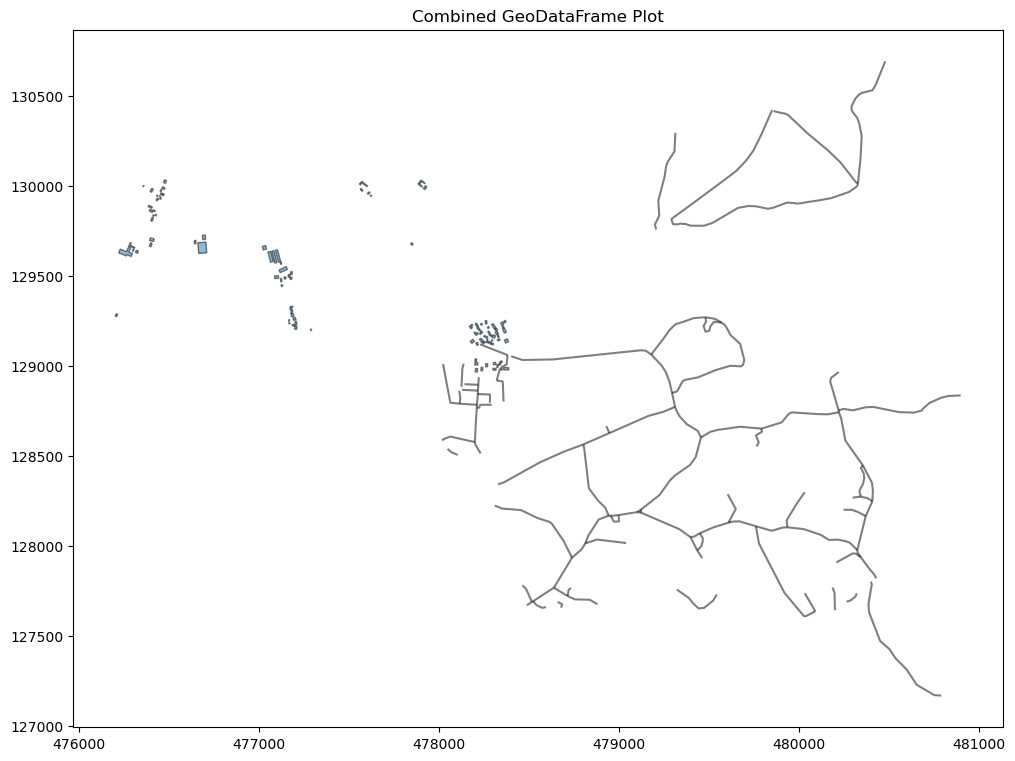

In [31]:
# Load the combined GeoDataFrame from the saved file
combined_gdf = gpd.read_file("./output_geojsons/combined_data.geojson")

# Plot the geometries
fig, ax = plt.subplots(figsize=(12, 12))
combined_gdf.plot(ax=ax, alpha=0.5, edgecolor="black")
ax.set_title("Combined GeoDataFrame Plot")
plt.show()

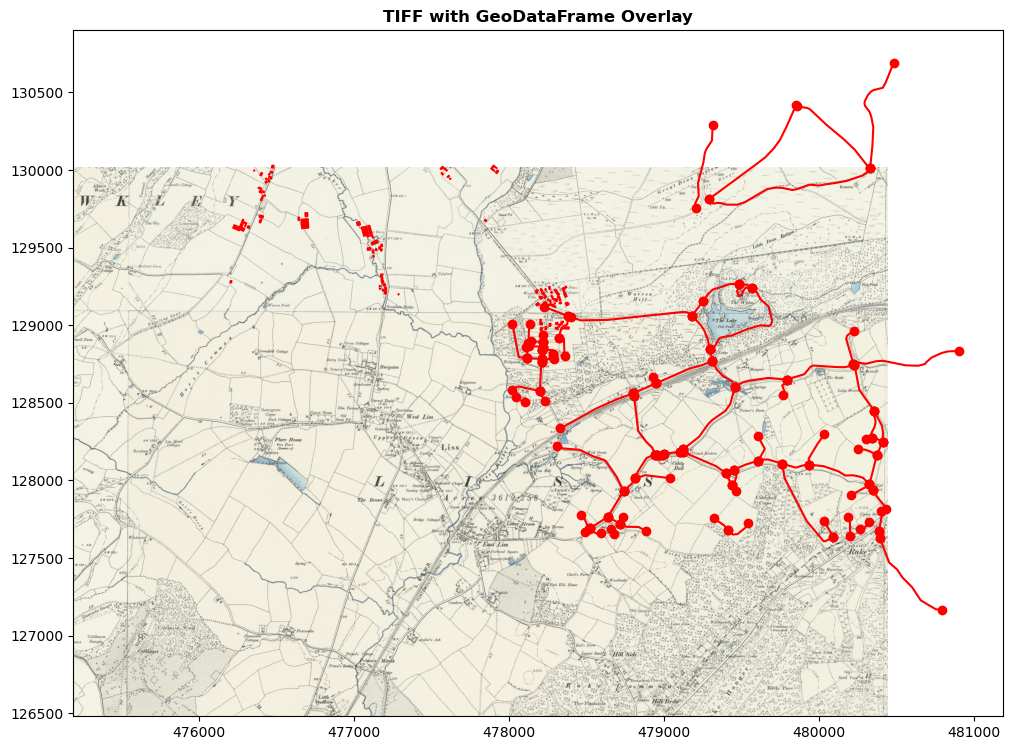

In [13]:
# plot over the tif as better reference espg:27700
import rasterio
from rasterio.plot import show

# Path to your TIFF file
tiff_path = "./data/6_inch_png/map_101433939.tif"

# Plot GeoDataFrame over the TIFF image
def plot_gdf_over_tiff(tiff_path, gdf, alpha=0.5, overlay_color="red"):
    """
    Plot a GeoDataFrame over a TIFF file.
    
    Parameters:
    - tiff_path: Path to the TIFF file.
    - gdf: GeoDataFrame to overlay.
    - alpha: Transparency level for the overlay.
    - overlay_color: Color of the overlay geometries.
    """
    with rasterio.open(tiff_path) as src:
        # Ensure GeoDataFrame CRS matches the TIFF CRS
        if gdf.crs is None:
            raise ValueError("GeoDataFrame does not have a CRS.")
        if not gdf.crs.equals(src.crs):
            print(f"Reprojecting GeoDataFrame from {gdf.crs} to {src.crs}")
            gdf = gdf.to_crs(src.crs)

        # Plot the TIFF
        fig, ax = plt.subplots(figsize=(12, 12))
        show(src, ax=ax, title="TIFF with GeoDataFrame Overlay")

        # Overlay the GeoDataFrame
        gdf.boundary.plot(ax=ax, color=overlay_color, linewidth=1, alpha=alpha)
        gdf.plot(ax=ax, alpha=alpha, color=overlay_color)
        
        plt.show()

# Call the function
plot_gdf_over_tiff(tiff_path, combined_gdf, alpha=1, overlay_color="red")

## Batch with mapreader 'maps'

In [ ]:
# Initialize a dictionary to store combined GeoDataFrames for each product
combined_gdfs = {product_key: gpd.GeoDataFrame() for product_key in ["zoomstack_local_buildings", "zoomstack_roads_local"]}

# Transform and process maps
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)

for parent_id in maps.list_parents():
    bbox = maps.parents[parent_id]["coordinates"]
    crs = maps.parents[parent_id]["crs"]
    print(f"Processing map: {parent_id} with bbox: {bbox} and CRS: {crs}")

    for product_key, product_info in PRODUCTS.items():
        if product_key not in combined_gdfs:
            continue  # Skip products not in the current selection

        print(f"Querying product: {product_info['description']} for map {parent_id}")
        try:
            gdf = downloader.download_os_data(
                tiff_path=None,  # Not used in this workflow
                product_name=product_key,
                bbox=bbox,
                crs=crs,
                output_file=os.path.join(output_dir, f"{parent_id}_{product_key}.geojson"),
            )
            if gdf is not None:
                # Append data to the combined GeoDataFrame for the product
                combined_gdfs[product_key] = pd.concat([combined_gdfs[product_key], gdf], ignore_index=True)
                print(f"Saved {product_info['description']} data for {parent_id} to {output_dir}/{parent_id}_{product_key}.geojson")
        except Exception as e:
            print(f"Error querying {product_info['description']} for map {parent_id}: {e}")

# Save combined GeoDataFrames
for product_key, combined_gdf in combined_gdfs.items():
    if not combined_gdf.empty:
        combined_file = os.path.join(output_dir, f"combined_{product_key}.geojson")
        combined_gdf.to_file(combined_file, driver="GeoJSON")
        print(f"Saved combined GeoDataFrame for {product_key} to {combined_file}")

Processing map: map_101441205.png with bbox: (456216.55070081836, 119125.86045758182, 461266.2604180551, 122451.3854629015) and CRS: EPSG:27700
Querying product: Generalized building footprints at the local resolution. for map map_101441205.png
Saved Generalized building footprints at the local resolution. data for map_101441205.png to ./output_geojsons//map_101441205.png_zoomstack_local_buildings.geojson
Querying product: Lines representing local roads. for map map_101441205.png
Saved Lines representing local roads. data for map_101441205.png to ./output_geojsons//map_101441205.png_zoomstack_roads_local.geojson
Processing map: map_101433939.png with bbox: (475190.9730177615, 126479.59100778133, 480441.01084478915, 130014.01912229758) and CRS: EPSG:27700
Querying product: Generalized building footprints at the local resolution. for map map_101433939.png
Saved Generalized building footprints at the local resolution. data for map_101433939.png to ./output_geojsons//map_101433939.png_zoom

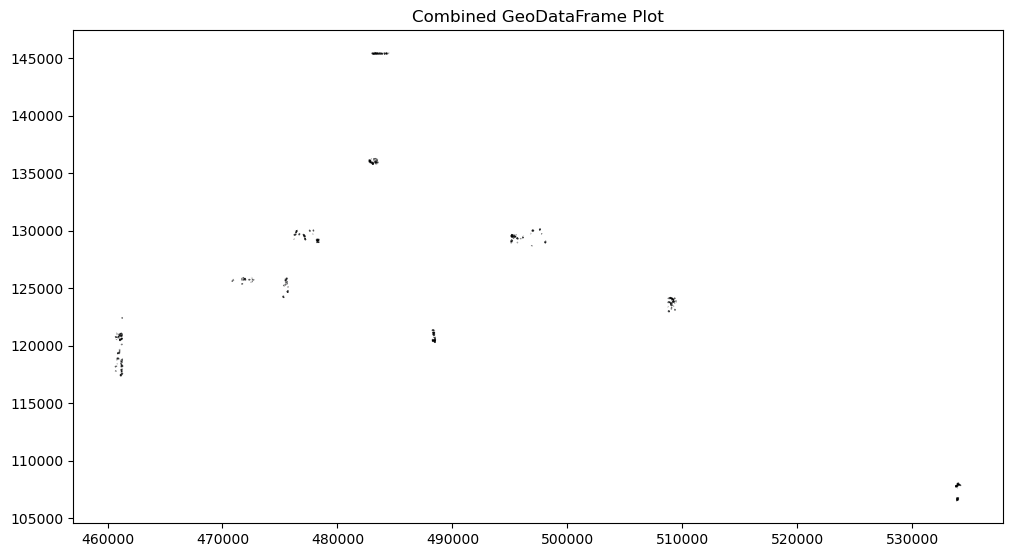

In [22]:
# Load the combined GeoDataFrame from the saved file
combined_gdf = gpd.read_file("./output_geojsons/combined_zoomstack_local_buildings.geojson")

# Plot the geometries
fig, ax = plt.subplots(figsize=(12, 12))
combined_gdf.plot(ax=ax, alpha=0.5, edgecolor="black")
ax.set_title("Combined GeoDataFrame Plot")
plt.show()


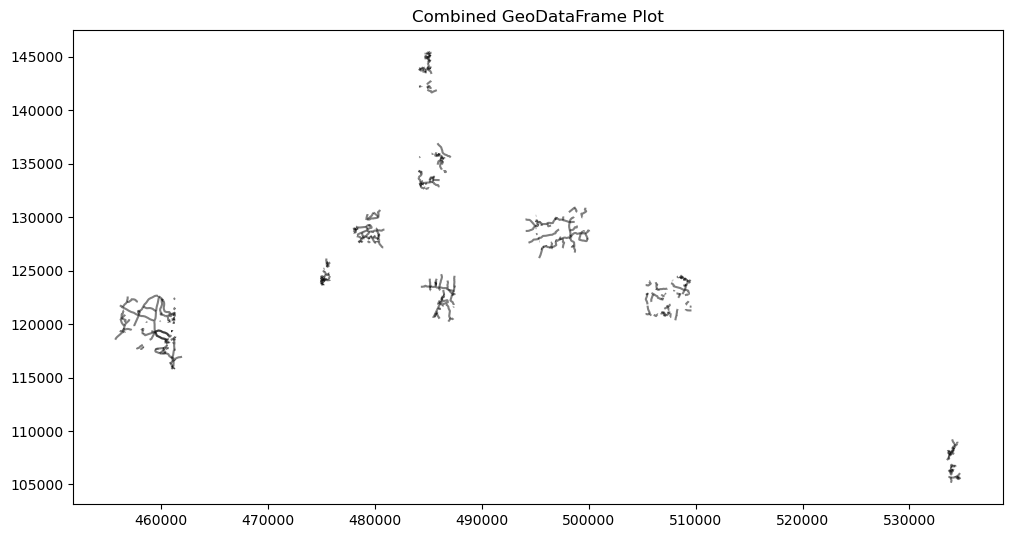

In [24]:
# Load the combined GeoDataFrame from the saved file
combined_gdf = gpd.read_file("./output_geojsons/combined_zoomstack_roads_local.geojson")

# Plot the geometries
fig, ax = plt.subplots(figsize=(12, 12))
combined_gdf.plot(ax=ax, alpha=0.5, edgecolor="black")
ax.set_title("Combined GeoDataFrame Plot")
plt.show()